## Fine-tuning

Unfreeaing a few of the top layers of a frozen model base used for feature extraction.

Steps for fine-tuning: 

* Add custom network on top of an already-trained base network.
* Freeze the base network.
* Train the part you added.
* Unfreeze some layers in the base network.
* Jointly train both these layers and the part you added.

Why not fine-tune more layers?

* Earlier layers encode more generic, reusable features.
* Overfitting.

In [1]:
''' Import convolutional base '''

from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

conv_base.summary()

Using TensorFlow backend.


58892288/58889256 [==============================] - 5s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool

In [3]:
''' Freezing all layers up to a specific one '''

# First - find out the name of the first trainable layer.

# Here - 'block5_conv1'

conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [4]:
''' Build model '''

from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5)) # without it, val_acc=96%
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [5]:
''' Make augmented data generators '''

import os
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/input'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_datagen = ImageDataGenerator(rescale=1./255,
                                  rotation_range=40,
                                  width_shift_range=0.2,
                                  height_shift_range=0.2,
                                  shear_range=0.2,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150), # this parameter would differ for another pretrained conv_base
    batch_size=20,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [6]:
''' Compile, train and save model '''

from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
    train_generator,
    steps_per_epoch=100,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=50)

model.save('cats_and_dogs_fine-tuned_aug.h5')

Epoch 1/30
100/100 [==============================] - 31s 307ms/step - loss: 0.6632 - acc: 0.6150 - val_loss: 0.4243 - val_acc: 0.8230
Epoch 2/30
100/100 [==============================] - 25s 250ms/step - loss: 0.4995 - acc: 0.7565 - val_loss: 0.2951 - val_acc: 0.8690
Epoch 3/30
100/100 [==============================] - 25s 250ms/step - loss: 0.3903 - acc: 0.8165 - val_loss: 0.2310 - val_acc: 0.9040
Epoch 4/30
100/100 [==============================] - 25s 250ms/step - loss: 0.3476 - acc: 0.8485 - val_loss: 0.2080 - val_acc: 0.9100
Epoch 5/30
100/100 [==============================] - 25s 251ms/step - loss: 0.3220 - acc: 0.8580 - val_loss: 0.2231 - val_acc: 0.9100
Epoch 6/30
100/100 [==============================] - 25s 252ms/step - loss: 0.3076 - acc: 0.8545 - val_loss: 0.2049 - val_acc: 0.9250
Epoch 7/30
100/100 [==============================] - 25s 252ms/step - loss: 0.2794 - acc: 0.8765 - val_loss: 0.1801 - val_acc: 0.9240
Epoch 8/30
100/100 [==============================] - 2

In [7]:
''' Saving model to somewhere '''

model.save('/output/cats_and_dogs_fine-tuned_aug.h5')

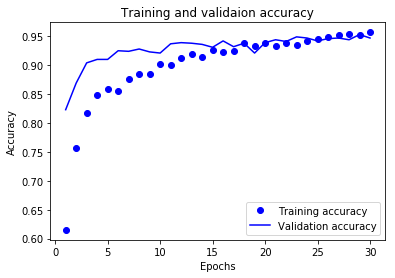

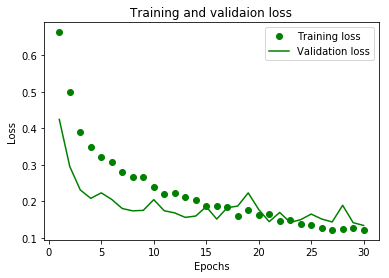

In [9]:
''' Plotting the results '''

import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validaion accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'go', label='Training loss')
plt.plot(epochs, val_loss, 'g', label='Validation loss')
plt.title('Training and validaion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

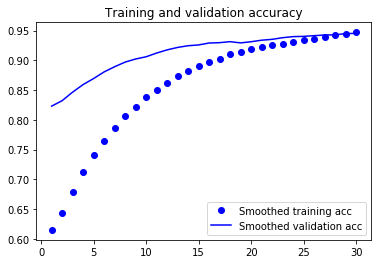

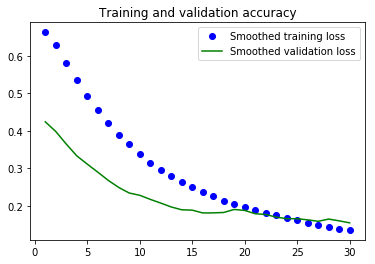

In [11]:
''' Plot smoothed accuracy and loss '''

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, 
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs, 
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, 
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs, 
         smooth_curve(val_loss), 'g', label='Smoothed validation loss')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [12]:
''' Evaluate best model on test dataset '''

test_dir = os.path.join(base_dir, 'test')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test accuracy:', test_acc)

Found 1000 images belonging to 2 classes.
test accuracy: 0.9229999959468842
